# dense-crowd-counting_crowdnet

In [40]:
#%matplotlib inline
import cv2
# from matplotlib import pyplot as plt
import numpy as np
import scipy.io
from skimage.transform import downscale_local_mean
import os
import sys
import json
import math
import time
import random
from random import shuffle
import pickle
import h5py
import glob

#caffe
caffe_root = os.path.expanduser('/home/reins/Desktop/caffe') # change with your install location
sys.path.insert(0, os.path.join(caffe_root, 'python'))
sys.path.insert(0, os.path.join(caffe_root, 'python/caffe/proto'))
import caffe
import caffe_pb2

In [41]:
#constants
import os

model_name = 'dcc_crowdnet'
model_path = os.path.expanduser(os.path.join('models', model_name))
data_path = os.path.expanduser(os.path.join('./data', model_name))
weights_path = os.path.expanduser(os.path.join('./models', model_name))

dataset_paths = ['dataset/UCF_CC_50']

slice_w = 256
slice_h = 256

patch_w = 225
patch_h = 225

net_density_h = 28
net_density_w = 28

HAS_GPU = True
GPU_ID = 0

In [42]:
#mean
VGG_ILSVRC_16_layers_mean = np.zeros((3, patch_h, patch_w), dtype='f4')
VGG_ILSVRC_16_layers_mean[0,:,:] = 103.939
VGG_ILSVRC_16_layers_mean[1,:,:] = 116.779
VGG_ILSVRC_16_layers_mean[2,:,:] = 123.68

# DCC Train

In [43]:
def load_gt_from_json(gt_file, gt_shape):
    gt = np.zeros(gt_shape, dtype='uint8') 
    with open(gt_file, 'r') as jf:
        for j, dot in enumerate(json.load(jf)):
            try:
                gt[int(math.floor(dot['y'])), int(math.floor(dot['x']))] = 1
            except IndexError:
                print gt_file, dot['y'], dot['x'], sys.exc_info()
    return gt

def load_images_and_gts(path):
    images = []
    gts = []
    densities = []
    for gt_file in glob.glob(os.path.join(path, '*.json')):
        print gt_file
        if os.path.isfile(gt_file.replace('.json','.png')):
            img = cv2.imread(gt_file.replace('.json','.png'))
        else:
            img = cv2.imread(gt_file.replace('.json','.jpg'))
        images.append(img)
        
        #load ground truth
        gt = load_gt_from_json(gt_file, img.shape[:-1])
        gts.append(gt)
        
        #densities
        desnity_file = gt_file.replace('.json','.h5')
        if os.path.isfile(desnity_file):
            #load density if exist
            with h5py.File(desnity_file, 'r') as hf:
                density = np.array(hf.get('density'))
        else:
            density = gaussian_filter_density([gt])[0]
            with h5py.File(desnity_file, 'w') as hf:
                hf['density'] = density
        densities.append(density)
    print path, len(images), 'loaded'
    return (images, gts, densities)

In [44]:
def density_resize(density, fx, fy):
    return cv2.resize(density, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)/(fx*fy)

def multiscale_pyramidal(images, gts, start=0.5, end=1.3, step=0.1):
    frange = np.arange(start, end, step)
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        for f in frange:
            out_images.append(cv2.resize(img, None, fx=f, fy=f, interpolation = cv2.INTER_CUBIC))
            out_gts.append(density_resize(gts[i], fx=f, fy=f))
    return (out_images, out_gts)

def adapt_images_and_densities(images, gts, slice_w=slice_w, slice_h=slice_h):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        n_slices_h = int(round(img_h/slice_h))
        n_slices_w = int(round(img_w/slice_w))
        new_img_h = float(n_slices_h * slice_h)
        new_img_w = float(n_slices_w * slice_w)
        fx = new_img_w/img_w
        fy = new_img_h/img_h
        out_images.append(cv2.resize(img, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC))
        assert out_images[-1].shape[0]%slice_h == 0 and out_images[-1].shape[1]%slice_w == 0
        if gts is not None:
            out_gts.append(density_resize(gts[i], fx, fy))
    return (out_images, out_gts)

#Generate slices
def generate_slices(images, gts, slice_w=slice_w, slice_h=slice_h, offset=None):
    if offset == None:
        offset = slice_w
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape        
        p_y_id = 0
        p_y1 = 0
        p_y2 = p_y1 + slice_h
        while p_y2 <= img_h:
            p_x_id = 0
            p_x1 = 0
            p_x2 = p_x1 + slice_w
            while p_x2 <= img_w:
                out_images.append(img[p_y1:p_y2,p_x1:p_x2])
                assert out_images[-1].shape[:-1] == (slice_h, slice_w)
                if gts is not None:
                    out_gts.append(gts[i][p_y1:p_y2,p_x1:p_x2])
                    assert out_gts[-1].shape == (slice_h, slice_w)
                #next
                p_x_id += 1
                p_x1 += offset
                p_x2 += offset
            p_y_id += 1
            p_y1 += offset
            p_y2 += offset
    return (out_images, out_gts)

#Data augmentation: CROP
def crop_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        #data augmentation
        #crop-5
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #top-left
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #top-right
        p_y1, p_y2 = 0, patch_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-left
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = 0, patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #bottom-right
        p_y1, p_y2 = img_h-patch_h, img_h
        p_x1, p_x2 = img_w-patch_w, img_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
        #center
        p_y1, p_y2 = int((img_h-patch_h)/2), int((img_h-patch_h)/2)+patch_h
        p_x1, p_x2 = int((img_w-patch_w)/2), int((img_w-patch_w)/2)+patch_w
        out_images.append(img[p_y1:p_y2,p_x1:p_x2])
        out_gts.append(gt[p_y1:p_y2,p_x1:p_x2])
    return (out_images, out_gts)


#Data augmentation: FLIP
def flip_slices(images, gts):
    out_images = []
    out_gts = []
    for i, img in enumerate(images):
        img_h, img_w, _ = img.shape
        gt = gts[i]
        #original
        out_images.append(img)
        out_gts.append(gt)
        #flip: left-right
        out_images.append(np.fliplr(img))
        out_gts.append(np.fliplr(gt))
    return (out_images, out_gts)

#Shuffling
def shuffle_slices(images, gts):
    out_images = []
    out_gts = []
    index_shuf = range(len(images))
    shuffle(index_shuf)
    for i in index_shuf:
        out_images.append(images[i])
        out_gts.append(gts[i])
    return (out_images, out_gts)

def samples_distribution(images, gts):
    out_images = []
    out_gts = []
    gts_count = map(np.sum, gts)
    max_count = max(gts_count)
    #pos
    for i, img in enumerate(images):
        if gts_count[i] >= 1. and random.random() < gts_count[i]**2/max_count**2:
            out_images.append(img)
            out_gts.append(gts[i])
    #neg
    neg_count = sum(gt_count < 1. for gt_count in gts_count)
    obj_neg_count = len(out_gts) / 6 # ~= 15-16%
    neg_keep_prob = min(1., float(obj_neg_count) / float(neg_count))
    for i, img in enumerate(images):
        if gts_count[i] < 1. and random.random() < neg_keep_prob:
            out_images.append(img)
            out_gts.append(gts[i])
        
    return (out_images, out_gts)

In [45]:
from scipy import stats

def gaussian_filter_density(gts):
    densities = []
    for gt in gts:
        print gt.shape
        density = np.zeros(gt.shape, dtype=np.float32)
        gt_count = np.count_nonzero(gt)
        if gt_count == 0:
            return density

        pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
        leafsize = 2048
        # build kdtree
        #print 'build kdtree...'
        tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
        # query kdtree
        #print 'query kdtree...' 
        distances, locations = tree.query(pts, k=2, eps=10.)

        #print 'generate density...'
        for i, pt in enumerate(pts):
            pt2d = np.zeros(gt.shape, dtype=np.float32)
            pt2d[pt[1],pt[0]] = 1.
            if gt_count > 1:
                sigma = distances[i][1]
            else:
                sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
            density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        #print 'done.'
        densities.append(density)
    return densities

In [46]:
# Positive image and ground truth loading
X_fs = []
Y_fs = []

for path in dataset_paths:
    images, gts, densities = load_images_and_gts(path)
    X_fs += images
    Y_fs += densities

dataset/UCF_CC_50/46.json
dataset/UCF_CC_50/22.json
dataset/UCF_CC_50/30.json
dataset/UCF_CC_50/13.json
dataset/UCF_CC_50/47.json
dataset/UCF_CC_50/15.json
dataset/UCF_CC_50/37.json
dataset/UCF_CC_50/34.json
dataset/UCF_CC_50/12.json
dataset/UCF_CC_50/20.json
dataset/UCF_CC_50/20.json 62.5052080551 637.235751295 (<type 'exceptions.IndexError'>, IndexError('index 637 is out of bounds for axis 1 with size 600',), <traceback object at 0x7fc7925f1680>)
dataset/UCF_CC_50/1.json
dataset/UCF_CC_50/1.json 149.348202471 984.256638928 (<type 'exceptions.IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x7fc77e855d40>)
dataset/UCF_CC_50/1.json 533.503642886 984.256638928 (<type 'exceptions.IndexError'>, IndexError('index 984 is out of bounds for axis 1 with size 984',), <traceback object at 0x7fc7925f1680>)
dataset/UCF_CC_50/40.json
dataset/UCF_CC_50/25.json
dataset/UCF_CC_50/44.json
dataset/UCF_CC_50/39.json
dataset/UCF_CC_50/49.json
dataset/

In [47]:
# Split test an train set
from sklearn.model_selection import train_test_split

# Train 80%, Test 20%
X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs, Y_fs, test_size=0.2)

In [51]:
# FS: FULL SIZE
X_train, Y_train = X_fs_train, Y_fs_train
X_test, Y_test = X_fs_test, Y_fs_test

# DATA AUGMENTATION
print '\nMultiscale pyramidal'
print 'TRAIN:'
X_train, Y_train = multiscale_pyramidal(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = multiscale_pyramidal(X_test, Y_test)
print len(X_test), len(Y_test)

# PATCH SIZE
print '\nGenerate slices'
print 'TRAIN:'
X_train, Y_train = generate_slices(X_train, Y_train, slice_w=patch_w, slice_h=patch_h, offset=8)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = generate_slices(X_test, Y_test, slice_w=patch_w, slice_h=patch_h)
print len(X_test), len(Y_test)

print '\nFlip'
print 'TRAIN:'
X_train, Y_train = flip_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, Y_test = flip_slices(X_test, Y_test)
print len(X_test), len(Y_test)

print '\nSamples gt distribution correction'
print 'TRAIN:'
X_train, Y_train = samples_distribution(X_train, Y_train)
print len(X_train), len(Y_train)

print '\nShuffle'
print 'TRAIN:'
X_train, Y_train = shuffle_slices(X_train, Y_train)
print len(X_train), len(Y_train)
print 'TEST:'
X_test, y_test = shuffle_slices(X_test, Y_test)
print len(X_test), len(Y_test)


Multiscale pyramidal
TRAIN:
320 320
TEST:
80 80

Generate slices
TRAIN:
1094166 1094166
TEST:
641 641

Flip
TRAIN:
2188332 2188332
TEST:
1282 1282

Samples gt distribution correction
TRAIN:
34943 34943

Shuffle
TRAIN:
34943 34943
TEST:
1282 1282


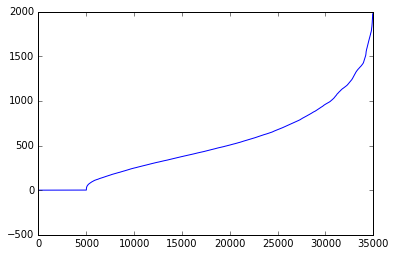

In [52]:
#Plot TRAIN samples distribution
from matplotlib import pyplot as plt

Y_train_sum = filter(lambda x: True, map(np.sum, Y_train))
Y_train_sum.sort()
plt.plot(Y_train_sum)
plt.show()

In [53]:
# Write out the data to HDF5 files

def process_dump_to_hdf5data(X, Y, path, phase, mean):
    if not os.path.exists(path):
        os.makedirs(path)
    
    batch_size = 700 #due to hf5 files size limit
    
    X_process = np.zeros((batch_size, 3, patch_h, patch_w), dtype=np.float32) 
    Y_process = np.zeros((batch_size, net_density_h, net_density_w), dtype=np.float32)
    
    with open(os.path.join(path, phase+'.txt'), 'w') as f:
        i1 = 0
        while i1 < len(X):
            if i1+batch_size < len(X):
                i2 = i1+batch_size
            else:
                i2 = len(X)
            print i1,'-', i2-1,'/',len(X)
            file_name = os.path.join(path, phase+'_'+str(i1)+'.h5')
            with h5py.File(file_name, 'w') as hf:
                #process batch
                for j, img in enumerate(X[i1:i2]):
                    X_process[j] = img.copy().transpose(2,0,1).astype(np.float32) - mean
                    Y_process[j] = density_resize(Y[i1+j], fx=float(net_density_w)/patch_w, fy=float(net_density_h)/patch_h)
                hf['data'] = X_process[:(i2-i1)]
                hf['label'] = Y_process[:(i2-i1)]
            f.write(file_name + '\n')
            i1 += batch_size
            

# Train
print 'TRAIN:'
process_dump_to_hdf5data(X_train, Y_train, data_path, 'train', VGG_ILSVRC_16_layers_mean)
# Test
print 'TEST:'
process_dump_to_hdf5data(X_test, Y_test, data_path, 'test', VGG_ILSVRC_16_layers_mean)

TRAIN:
0 - 699 / 34943
700 - 1399 / 34943
1400 - 2099 / 34943
2100 - 2799 / 34943
2800 - 3499 / 34943
3500 - 4199 / 34943
4200 - 4899 / 34943
4900 - 5599 / 34943
5600 - 6299 / 34943
6300 - 6999 / 34943
7000 - 7699 / 34943
7700 - 8399 / 34943
8400 - 9099 / 34943
9100 - 9799 / 34943
9800 - 10499 / 34943
10500 - 11199 / 34943
11200 - 11899 / 34943
11900 - 12599 / 34943
12600 - 13299 / 34943
13300 - 13999 / 34943
14000 - 14699 / 34943
14700 - 15399 / 34943
15400 - 16099 / 34943
16100 - 16799 / 34943
16800 - 17499 / 34943
17500 - 18199 / 34943
18200 - 18899 / 34943
18900 - 19599 / 34943
19600 - 20299 / 34943
20300 - 20999 / 34943
21000 - 21699 / 34943
21700 - 22399 / 34943
22400 - 23099 / 34943
23100 - 23799 / 34943
23800 - 24499 / 34943
24500 - 25199 / 34943
25200 - 25899 / 34943
25900 - 26599 / 34943
26600 - 27299 / 34943
27300 - 27999 / 34943
28000 - 28699 / 34943
28700 - 29399 / 34943
29400 - 30099 / 34943
30100 - 30799 / 34943
30800 - 31499 / 34943
31500 - 32199 / 34943
32200 - 32899 /

### Visualize

In [35]:
def list_to_np_array(in_list):
    max_h = 0
    max_w = 0
    for i, item in enumerate(in_list):
        if item.shape[0] > max_h:
            max_h = item.shape[0]
        if item.shape[1] > max_w:
            max_w = item.shape[1]
    out_arr = np.zeros((len(in_list), max_h, max_w, 3))
    for i, item in enumerate(in_list):
        pad_h = max_h - item.shape[0]
        pad_w = max_w - item.shape[1]
        out_arr[i] = np.pad(item, ((0,pad_h),(0,pad_w),(0,0)), mode='constant', constant_values=0.)
    return out_arr

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.figure(figsize=(30,30))
    plt.imshow(data)
    plt.axis('off')

In [ ]:
vis_square(list_to_np_array(X_train[:20]))

In [ ]:
#visualize one random density
i = int(random.random()*len(Y_train))
print i
print np.sum(Y_train[i])
plt.imshow(np.fliplr(Y_train[i]))

In [ ]:
# TODO: download http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel

In [1]:
# caffe train
!/home/reins/Desktop/caffe/build/tools/caffe train -solver models/dcc_crowdnet/solver.prototxt -weights weights/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel

I0820 18:46:15.176201 17956 caffe.cpp:197] Use CPU.
I0820 18:46:15.200371 17956 solver.cpp:45] Initializing solver from parameters: 
test_iter: 100
test_interval: 1
base_lr: 1e-07
display: 100
max_iter: 1
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 100000
snapshot: 1000
snapshot_prefix: "models/dcc_crowdnet/dcc_crowdnet_train"
solver_mode: CPU
net: "models/dcc_crowdnet/train_val.prototxt"
train_state {
  level: 0
  stage: ""
}
weights: "weights/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel"
I0820 18:46:15.200558 17956 solver.cpp:102] Creating training net from net file: models/dcc_crowdnet/train_val.prototxt
I0820 18:46:15.201380 17956 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0820 18:46:15.201841 17956 net.cpp:51] Initializing net from parameters: 
name: "dcc_crowdnet"
state {
  phase: TRAIN
  level: 0
  stage: ""
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  incl

I0820 18:46:15.252992 17956 hdf5_data_layer.cpp:94] Number of HDF5 files: 50
I0820 18:46:15.491756 17956 hdf5.cpp:32] Datatype class: H5T_FLOAT
I0820 18:46:18.592631 17956 net.cpp:122] Setting up data
I0820 18:46:18.592689 17956 net.cpp:129] Top shape: 10 3 225 225 (1518750)
I0820 18:46:18.592701 17956 net.cpp:129] Top shape: 10 28 28 (7840)
I0820 18:46:18.592715 17956 net.cpp:137] Memory required for data: 6106360
I0820 18:46:18.592744 17956 layer_factory.hpp:77] Creating layer data_data_0_split
I0820 18:46:18.592787 17956 net.cpp:84] Creating Layer data_data_0_split
I0820 18:46:18.592815 17956 net.cpp:406] data_data_0_split <- data
I0820 18:46:18.592845 17956 net.cpp:380] data_data_0_split -> data_data_0_split_0
I0820 18:46:18.592869 17956 net.cpp:380] data_data_0_split -> data_data_0_split_1
I0820 18:46:18.592886 17956 net.cpp:122] Setting up data_data_0_split
I0820 18:46:18.592900 17956 net.cpp:129] Top shape: 10 3 225 225 (1518750)
I0820 18:46:18.592911 17956 net.cpp:129] Top shap

I0820 18:46:18.690167 17956 net.cpp:122] Setting up conv4_2
I0820 18:46:18.690212 17956 net.cpp:129] Top shape: 10 512 29 29 (4305920)
I0820 18:46:18.690222 17956 net.cpp:137] Memory required for data: 1107390440
I0820 18:46:18.690246 17956 layer_factory.hpp:77] Creating layer relu4_2
I0820 18:46:18.690264 17956 net.cpp:84] Creating Layer relu4_2
I0820 18:46:18.690274 17956 net.cpp:406] relu4_2 <- conv4_2
I0820 18:46:18.690289 17956 net.cpp:367] relu4_2 -> conv4_2 (in-place)
I0820 18:46:18.690304 17956 net.cpp:122] Setting up relu4_2
I0820 18:46:18.690315 17956 net.cpp:129] Top shape: 10 512 29 29 (4305920)
I0820 18:46:18.690325 17956 net.cpp:137] Memory required for data: 1124614120
I0820 18:46:18.690333 17956 layer_factory.hpp:77] Creating layer conv4_3
I0820 18:46:18.690353 17956 net.cpp:84] Creating Layer conv4_3
I0820 18:46:18.690361 17956 net.cpp:406] conv4_3 <- conv4_2
I0820 18:46:18.690376 17956 net.cpp:380] conv4_3 -> conv4_3
I0820 18:46:18.724548 17956 net.cpp:122] Setting up

I0820 18:46:18.829928 17956 net.cpp:132]     with loss weight 1
I0820 18:46:18.878935 17956 net.cpp:137] Memory required for data: 1434448364
I0820 18:46:18.878970 17956 net.cpp:198] loss needs backward computation.
I0820 18:46:18.878983 17956 net.cpp:198] conv6 needs backward computation.
I0820 18:46:18.878989 17956 net.cpp:198] concat1 needs backward computation.
I0820 18:46:18.878995 17956 net.cpp:198] sw_pool3 needs backward computation.
I0820 18:46:18.879001 17956 net.cpp:198] sw_relu3 needs backward computation.
I0820 18:46:18.879006 17956 net.cpp:198] sw_conv3 needs backward computation.
I0820 18:46:18.879012 17956 net.cpp:198] sw_pool2 needs backward computation.
I0820 18:46:18.879019 17956 net.cpp:198] sw_relu2 needs backward computation.
I0820 18:46:18.879024 17956 net.cpp:198] sw_conv2 needs backward computation.
I0820 18:46:18.879029 17956 net.cpp:198] sw_pool1 needs backward computation.
I0820 18:46:18.879034 17956 net.cpp:198] sw_relu1 needs backward computation.
I0820 18

I0820 18:46:27.570353 17956 net.cpp:122] Setting up data
I0820 18:46:27.570405 17956 net.cpp:129] Top shape: 10 3 225 225 (1518750)
I0820 18:46:27.570417 17956 net.cpp:129] Top shape: 10 28 28 (7840)
I0820 18:46:27.570430 17956 net.cpp:137] Memory required for data: 6106360
I0820 18:46:27.570456 17956 layer_factory.hpp:77] Creating layer data_data_0_split
I0820 18:46:27.570477 17956 net.cpp:84] Creating Layer data_data_0_split
I0820 18:46:27.570487 17956 net.cpp:406] data_data_0_split <- data
I0820 18:46:27.570510 17956 net.cpp:380] data_data_0_split -> data_data_0_split_0
I0820 18:46:27.570529 17956 net.cpp:380] data_data_0_split -> data_data_0_split_1
I0820 18:46:27.570570 17956 net.cpp:122] Setting up data_data_0_split
I0820 18:46:27.570583 17956 net.cpp:129] Top shape: 10 3 225 225 (1518750)
I0820 18:46:27.570595 17956 net.cpp:129] Top shape: 10 3 225 225 (1518750)
I0820 18:46:27.570605 17956 net.cpp:137] Memory required for data: 18256360
I0820 18:46:27.570613 17956 layer_factory.

I0820 18:46:27.627398 17956 net.cpp:122] Setting up conv4_1
I0820 18:46:27.627449 17956 net.cpp:129] Top shape: 10 512 29 29 (4305920)
I0820 18:46:27.627463 17956 net.cpp:137] Memory required for data: 1072943080
I0820 18:46:27.627486 17956 layer_factory.hpp:77] Creating layer relu4_1
I0820 18:46:27.627512 17956 net.cpp:84] Creating Layer relu4_1
I0820 18:46:27.627526 17956 net.cpp:406] relu4_1 <- conv4_1
I0820 18:46:27.627540 17956 net.cpp:367] relu4_1 -> conv4_1 (in-place)
I0820 18:46:27.627560 17956 net.cpp:122] Setting up relu4_1
I0820 18:46:27.627578 17956 net.cpp:129] Top shape: 10 512 29 29 (4305920)
I0820 18:46:27.627585 17956 net.cpp:137] Memory required for data: 1090166760
I0820 18:46:27.627593 17956 layer_factory.hpp:77] Creating layer conv4_2
I0820 18:46:27.627612 17956 net.cpp:84] Creating Layer conv4_2
I0820 18:46:27.627621 17956 net.cpp:406] conv4_2 <- conv4_1
I0820 18:46:27.627635 17956 net.cpp:380] conv4_2 -> conv4_2
I0820 18:46:27.663991 17956 net.cpp:122] Setting up

[libprotobuf WARNING google/protobuf/io/coded_stream.cc:537] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:78] The total number of bytes read was 553432081
I0820 18:46:29.361641 17956 upgrade_proto.cpp:55] Attempting to upgrade input file specified using deprecated V1LayerParameter: weights/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel
I0820 18:46:29.981477 17956 upgrade_proto.cpp:63] Successfully upgraded file specified using deprecated V1LayerParameter
I0820 18:46:30.002028 17956 upgrade_proto.cpp:69] Attempting to upgrade input file specified using deprecated input fields: weights/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel
I0820 18:46:30.002066 17956 upgrade_proto.cpp:72] Su

## Test deploy

In [ ]:
def image_process(img, mean):
    img = img.copy()
    img = img.transpose(2, 0, 1).astype(np.float32)
    img -= mean
    return img
    
def batch_image_process(images, mean):
    batch = np.zeros((len(images),)+images[0].transpose(2, 0, 1).shape, dtype=np.float32)
    for i, img in enumerate(images):
        batch[i] = image_process(img, mean)
    return batch

In [ ]:
def predict(X_fs_deploy, mean):
    Y_fs_deploy = []
    for i, img in enumerate(X_fs_deploy):
        adapted_img, _ = adapt_images_and_densities([img], None, slice_w=patch_w, slice_h=patch_h)
        X_deploy, _ = generate_slices(adapted_img, None, slice_w=patch_w, slice_h=patch_h, offset=None)
        # net forward
        out_layer = 'conv6'
        batch_size = 10
        Y_deploy = []
        i1 = 0
        while i1 < len(X_deploy):
            if i1+batch_size < len(X_deploy):
                i2 = i1+batch_size
            else:
                i2 = len(X_deploy)
            batch = batch_image_process(X_deploy[i1:i2], mean)
            net.blobs['data'].reshape(batch.shape[0], batch.shape[1], batch.shape[2], batch.shape[3])
            net.blobs['data'].data[...] = batch
            net.forward() # end=penultimate_layer
            for out in net.blobs[out_layer].data:
                y = out[0] #single channel
                Y_deploy.append(y)
            i1 += batch_size
        Y_fs_deploy.append(Y_deploy)
    return Y_fs_deploy

In [ ]:
model_def = os.path.join(model_path, 'deploy.prototxt')
for model_weights in glob.glob(os.path.join(weights_path, '*.caffemodel')):
    net = caffe.Net(model_def, model_weights, caffe.TEST)
    if HAS_GPU:
        caffe.set_device(GPU_ID)
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()
    t1 = time.time()
    Y_fs_deploy = predict(X_fs_test, VGG_ILSVRC_16_layers_mean)
    print 'time:', time.time()-t1
    Y_fs_test_count = np.array(map(np.sum, Y_fs_test))
    Y_fs_deploy_count = np.array(map(np.sum, Y_fs_deploy))

    print model_weights, 'MAE:', np.average(np.absolute(Y_fs_deploy_count - Y_fs_test_count))